In [75]:
import pandas as pd
import numpy as np
import re
import torch
from PIL import Image
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from skimage import io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchaudio import load
import torchaudio
from IPython.display import Audio, display
import pandas as pd
import numpy as np
import torchaudio
import cv2
import os
from matplotlib import pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from matplotlib import cm
import time
import glob
from torch.autograd import Variable
from torchaudio import load
from pydub import AudioSegment
import moviepy.editor
import scipy.io.wavfile
import soundfile as sf
import math
import subprocess
from scipy import stats
import sys
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from mtcnn.mtcnn import MTCNN

In [76]:
sys.path.append('/path/to/ffmpeg')

In [77]:
from architectures import *

In [78]:
device = torch.device('cuda')

In [79]:
torch.cuda.empty_cache()

In [80]:
train = pd.read_csv('./task3/training.csv')
test = pd.read_csv('./task3/testing.csv')

In [81]:
class CustomDataLoader(Dataset):
    def __init__(self, csv_file, rootdir,transform = None, freq_threshold = 5):
        self.df = csv_file.copy()
        self.feature = self.df['image_num']
        self.label = self.df['emotion']
        self.root = rootdir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):   
        image = Image.open(os.path.join(self.root, self.df.iloc[index, 3]))
        y_label = torch.tensor(int(self.df.iloc[index, 0]))
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)

In [82]:
dim = 1600
def padding(wave, dimension, detach=True):  
    if detach: wv = wave.detach().numpy()
    cur = wave.shape[2]
    req = dim - cur
    ch = wave.shape[0]
    base = 3 - ch
    return np.pad(wv, ((0, base), (0, 0), (0, req)), 'constant')

In [83]:
class AudioCustomDataLoader(Dataset):
    def __init__(self, csv_file,transform = None, freq_threshold = 5):
        self.df = csv_file.copy()
        self.feature = self.df['audio']
        self.label = self.df['label']
        self.mfcc = torchaudio.transforms.MFCC(sample_rate=16000)
        #self.root = rootdir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index): 
        data, sampleRate = load(self.df.iloc[index, 0])
        data = self.mfcc(data)
        data = data[:, :, :dim]
        data = padding(data, dim)
        y_label = torch.tensor(int(self.df.iloc[index, 1]))
#         if self.transform:
#             data = self.transform(data)
            
        return (torch.tensor(data), y_label)

In [84]:
df = pd.read_csv('./audio.csv')
df

audio  label
0           ./Emotions/Fearful/1054_IEO_FEA_HI.wav      2
1             ./Emotions/Fearful/YAF_road_fear.wav      2
2      ./Emotions/Neutral/03-01-01-01-01-01-17.wav      6
3         ./Emotions/Disgusted/1070_ITS_DIS_XX.wav      1
4         ./Emotions/Disgusted/OAF_jar_disgust.wav      1
...                                            ...    ...
12793       ./Emotions/Neutral/1004_TSI_NEU_XX.wav      6
12794       ./Emotions/Fearful/1051_TIE_FEA_XX.wav      2
12795  ./Emotions/Neutral/03-01-01-01-01-01-23.wav      6
12796           ./Emotions/Happy/YAF_gin_happy.wav      3
12797         ./Emotions/Angry/YAF_death_angry.wav      0

[12798 rows x 2 columns]

In [85]:
mean = [0.4, 0.5, 0.5]
std = [0.4, 0.5, 0.5]


transform = transforms.Compose(
    [transforms.Resize((48, 48)),
#      transforms.Grayscale(num_output_channels = 1),
     transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ])

In [86]:
a = torch.load('./audio_model/audio_model.pt')

In [87]:
a

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [88]:
audio_dataset = AudioCustomDataLoader(csv_file = df,transform = None)
atrain_set, atest_set = torch.utils.data.random_split(audio_dataset, [10000, 2798])

atrain_loader = DataLoader(dataset = atrain_set, batch_size = 32, shuffle=True)
atest_loader = DataLoader(dataset = atest_set,batch_size = 32, shuffle=True)

In [128]:
# correct = 0
# total = 0
# predic = []
# tru = []
# with torch.no_grad():
#     for data in atest_loader:
#         images, labels = data
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = a(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         predic.extend(list(predicted.detach().cpu()))
#         tru.extend(list(labels.detach().cpu()))
#         correct += (predicted == labels).sum().item()
#     print('Accuracy:', 100 * correct // total, '%')

In [90]:
test

emotion        Usage                                             pixels  \
0           0   PublicTest  254 254 254 254 254 249 255 160 2 58 53 70 77 ...   
1           1   PublicTest  156 184 198 202 204 207 210 212 213 214 215 21...   
2           4   PublicTest  69 118 61 60 96 121 103 87 103 88 70 90 115 12...   
3           6   PublicTest  205 203 236 157 83 158 120 116 94 86 155 180 2...   
4           3   PublicTest  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...   
...       ...          ...                                                ...   
7173        6  PrivateTest  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...   
7174        3  PrivateTest  178 174 172 173 181 188 191 194 196 199 200 20...   
7175        0  PrivateTest  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...   
7176        3  PrivateTest  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...   
7177        2  PrivateTest  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...   

      image_num  
0     28709.jpg  
1     28710.jpg  
2     28711.jpg  
3     28712.jpg  
4     28713.jpg  
...         ...  
7173  35882.jpg  
7174  35883.jpg  
7175  35884.jpg  
7176  35885.jpg  
7177  35886.jpg  

[7178 rows x 4 columns]

In [91]:
train_set = CustomDataLoader(csv_file = train, rootdir = './task3/images/',transform = transform)
train_loader = DataLoader(dataset = train_set, batch_size = 128, shuffle=True)

test_set = CustomDataLoader(csv_file = test, rootdir = './task3/images/',transform = transform)
test_loader = DataLoader(dataset = test_set, batch_size = 1
                         , shuffle=False)

In [92]:
m = torch.load('./image_model/image_model.pt')

In [93]:
m.features

Sequential(
  (conv): Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(1280, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (activation): SiLU(inplace=True)
)

In [94]:
m.eval()

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [95]:
dim = 1600
def predict_audio(audio_path, nn):
    nn.eval()
    with torch.no_grad():
        mfcc = torchaudio.transforms.MFCC(sample_rate=16000)
        testAudio, testSampleRate = load(audio_path)
        data = mfcc(testAudio)
        data = data[:, :, :dim]
        data = padding(data, dim)
        nn.to(device)
        data = torch.tensor(data)
        outputs = nn(data.unsqueeze(0).to(device)).argmax()
    return outputs

In [96]:
def predict_image(image_path, nn):
    nn.eval()
    with torch.no_grad():
        image = Image.open(image_path)
        mean = [0.4, 0.5, 0.5]
        std = [0.4, 0.5, 0.5]
        transform = transforms.Compose(
            [transforms.Resize((48, 48)),
    #          transforms.Grayscale(num_output_channels = 3),
             transforms.ToTensor(),
            transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
            ])
        image = transform(image)
        #print(image.unsqueeze(0).size())
        outputs = nn(image.unsqueeze(0).to(device))
        _, predicted = torch.max(outputs.data, 1)
    return predicted

In [97]:
video = moviepy.editor.VideoFileClip("video.mp4")
audio = video.audio
audio.write_audiofile("voice.mp3")

MoviePy - Writing audio in voice.mp3


MoviePy - Done.


In [123]:
labels = {
        0:'Angry',
        1:'Disgusted',
        2:'Fearful',
        3:'Happy',
        6:'Neutral',
        4:'Sad',
        5:'Suprised'
    }

In [99]:
unit = 5000
sound = AudioSegment.from_mp3("voice.mp3") 
sound.export("voice.wav", format = "wav")
last_chunk_length = len(sound) % 5000
for i in range(len(sound) // unit):
    sound = AudioSegment.from_mp3("voice.mp3") 
    if (i == 0):  
        sound = sound[:unit]
        sound.export("./test_audio/audio" + str(i) + ".wav", format = "wav")
    else:
        sound = sound[unit:(unit + 5000)]
        sound.export("./test_audio/audio" + str(i) + ".wav", format = "wav")
    unit = unit + 5000
f = sf.SoundFile('voice.wav')
length = round(f.frames / f.samplerate)
audio_sentiment = []
for i in range(length // 5):
    audio_sentiment.append(predict_audio("./test_audio/audio" + str(i) + ".wav", a))

In [100]:
def get_length(filename):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", filename],
        stdout = subprocess.PIPE,
        stderr = subprocess.STDOUT)
    return float(result.stdout)

In [115]:
def get_frames(inputFile, outputFolder, step, count):
    step = step
    frames_count = count
    currentframe = 0
    frames_captured = 0
    try:  
        if not os.path.exists(outputFolder): 
            os.makedirs(outputFolder) 
    except OSError: 
        print ('Error! Could not create a directory') 
  
    cam = cv2.VideoCapture(inputFile) 
    frame_per_second = cam.get(cv2.CAP_PROP_FPS)

    while (True):
        ret, frame = cam.read()
        if ret:
            if currentframe > (step*frame_per_second):  
                currentframe = 0
                name = './data/frame' + str(frames_captured) + '.jpg' 
                cv2.imwrite(name, frame)       
                frames_captured+=1
                if frames_captured > frames_count-1:
                    ret = False
            currentframe += 1           
        if ret == False:
            break
    cam.release()
#     cv2.destroyAllWindows()

In [116]:
def draw_faces(filename, result_list, count):
    data = pyplot.imread(filename)
    for i in range(len(result_list)):
        x1, y1, width, height = result_list[i]['box']
        x2, y2 = x1 + width, y1 + height
        pyplot.axis('off')
        pyplot.imshow(data[y1:y2, x1:x2])
        img = './test_images/' + str(count) + "-" + str(i) + '.jpg'
        pyplot.savefig(img, bbox_inches = 'tight', pad_inches=0)
        pyplot.show()

In [117]:
get_frames("video.mp4", "data", 1, round(get_length("video.mp4")))

2/2 [==============================] - 0s 3ms/step


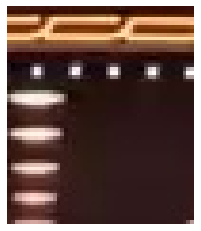

1/1 [==============================] - 0s 69ms/step


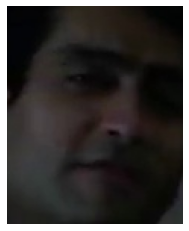

1/1 [==============================] - 0s 70ms/step


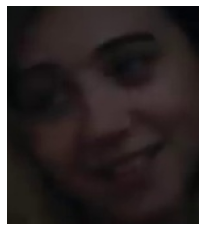

1/1 [==============================] - 0s 69ms/step


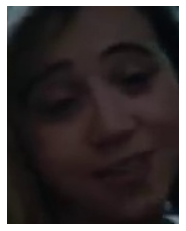

1/1 [==============================] - 0s 67ms/step


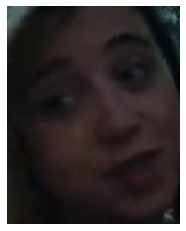

1/1 [==============================] - 0s 70ms/step


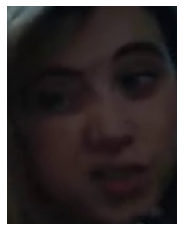

1/1 [==============================] - 0s 68ms/step


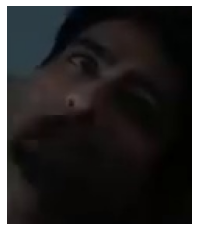

1/1 [==============================] - 0s 67ms/step


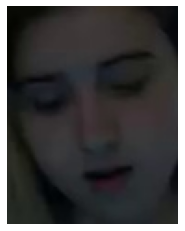

1/1 [==============================] - 0s 67ms/step


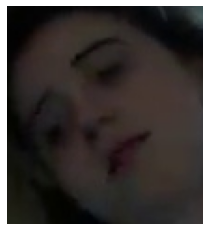

1/1 [==============================] - 0s 68ms/step


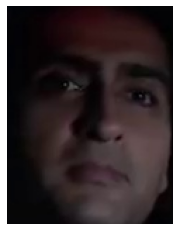

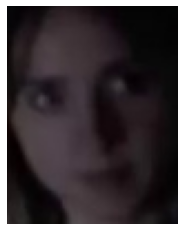

1/1 [==============================] - 0s 68ms/step


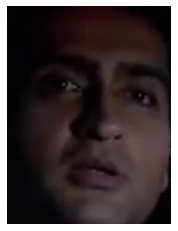

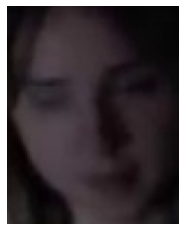

1/1 [==============================] - 0s 70ms/step


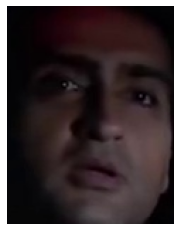

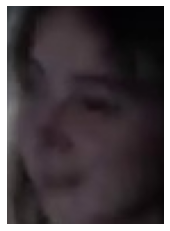

1/1 [==============================] - 0s 67ms/step


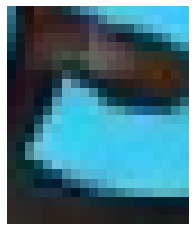

1/1 [==============================] - 0s 68ms/step


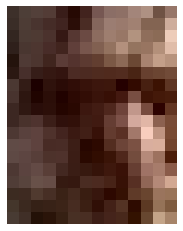

1/1 [==============================] - 0s 67ms/step


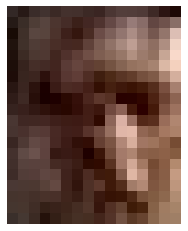

1/1 [==============================] - 0s 72ms/step


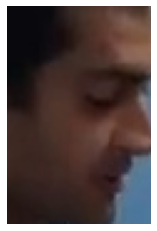

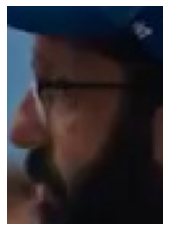

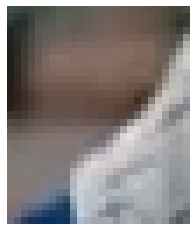

2/2 [==============================] - 0s 4ms/step


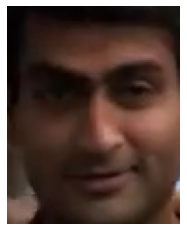

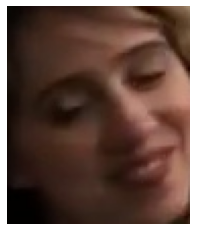

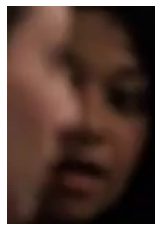

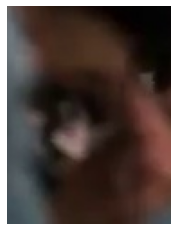

1/1 [==============================] - 0s 70ms/step


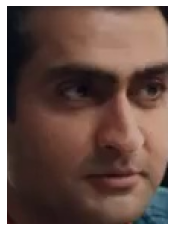

1/1 [==============================] - 0s 73ms/step


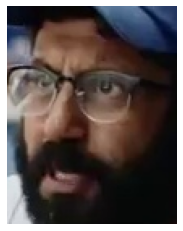

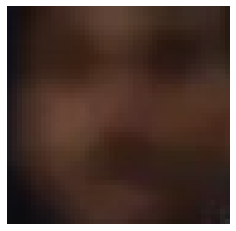

2/2 [==============================] - 0s 3ms/step


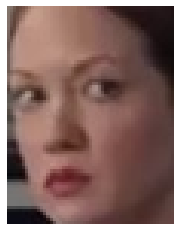

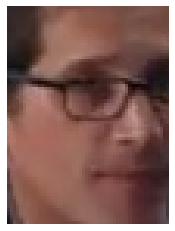

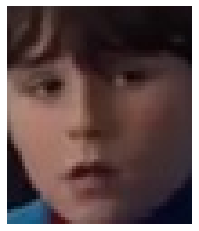

1/1 [==============================] - 0s 72ms/step


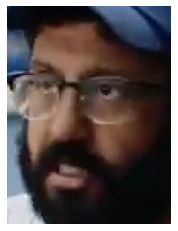

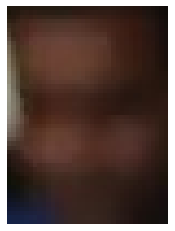

1/1 [==============================] - 0s 68ms/step


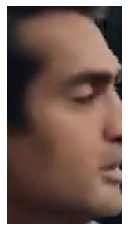

1/1 [==============================] - 0s 70ms/step


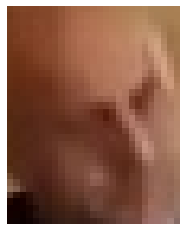

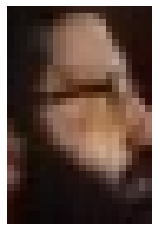

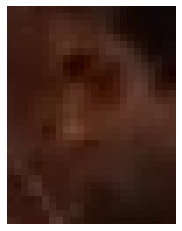

1/1 [==============================] - 0s 71ms/step


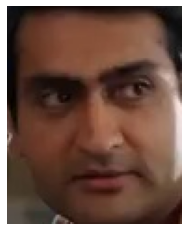

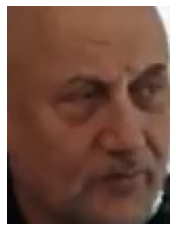

1/1 [==============================] - 0s 72ms/step


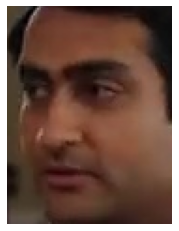

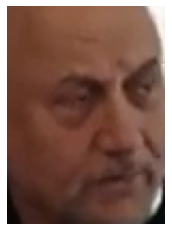

1/1 [==============================] - 0s 73ms/step


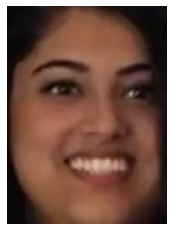

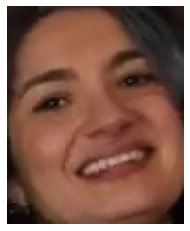

2/2 [==============================] - 0s 2ms/step


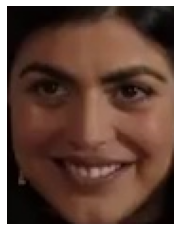

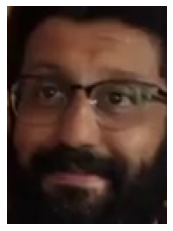

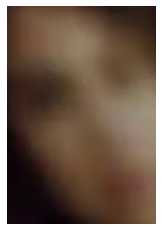

1/1 [==============================] - 0s 70ms/step


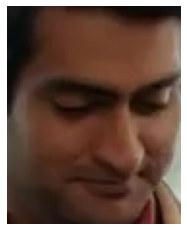

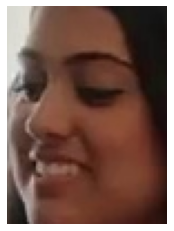

1/1 [==============================] - 0s 72ms/step


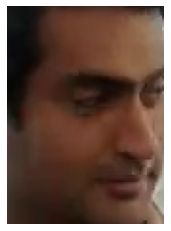

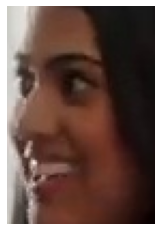

1/1 [==============================] - 0s 69ms/step


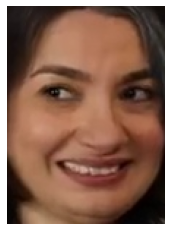

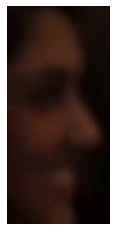

1/1 [==============================] - 0s 70ms/step


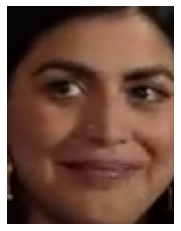

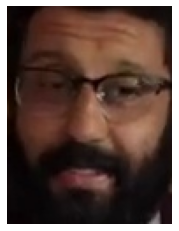

1/1 [==============================] - 0s 70ms/step


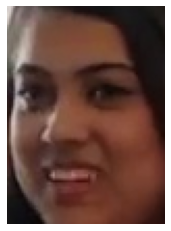

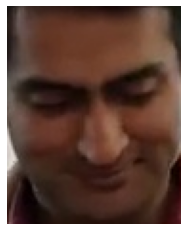

1/1 [==============================] - 0s 71ms/step


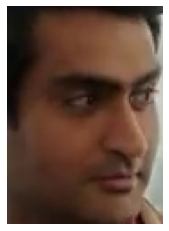

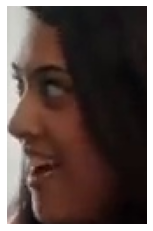

1/1 [==============================] - 0s 71ms/step


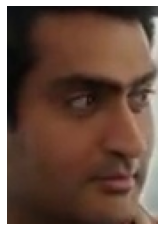

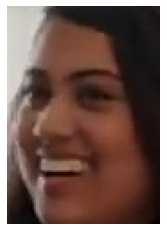

1/1 [==============================] - 0s 72ms/step


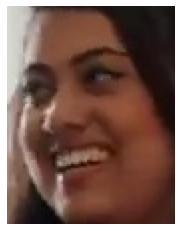

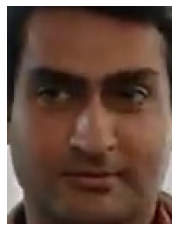

1/1 [==============================] - 0s 68ms/step


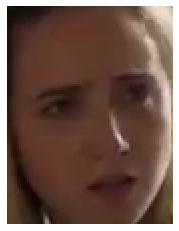

1/1 [==============================] - 0s 69ms/step


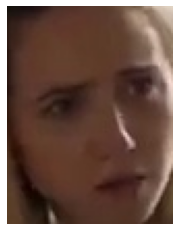

1/1 [==============================] - 0s 68ms/step


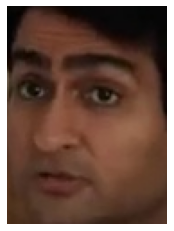

1/1 [==============================] - 0s 68ms/step


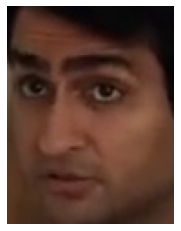

1/1 [==============================] - 0s 68ms/step


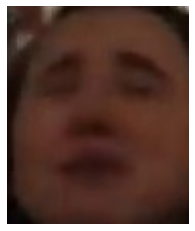

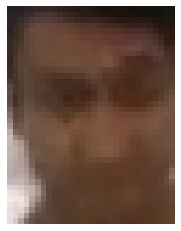

1/1 [==============================] - 0s 68ms/step


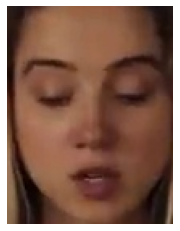

1/1 [==============================] - 0s 67ms/step


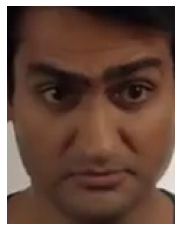

1/1 [==============================] - 0s 69ms/step


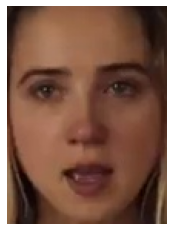

1/1 [==============================] - 0s 69ms/step


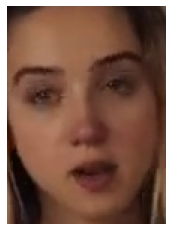

1/1 [==============================] - 0s 68ms/step


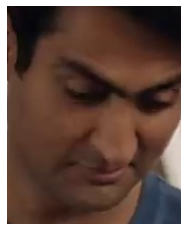

1/1 [==============================] - 0s 70ms/step


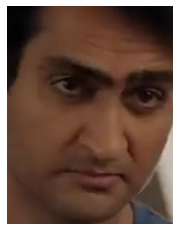

1/1 [==============================] - 0s 71ms/step


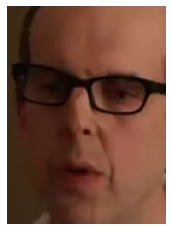

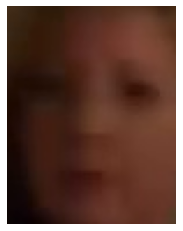

1/1 [==============================] - 0s 69ms/step


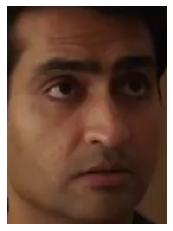

1/1 [==============================] - 0s 67ms/step


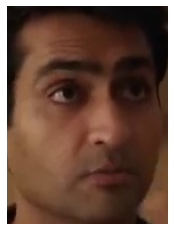

1/1 [==============================] - 0s 70ms/step


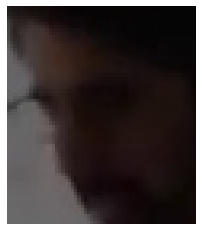

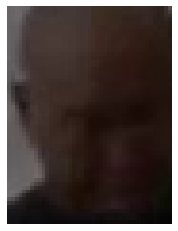

2/2 [==============================] - 0s 3ms/step


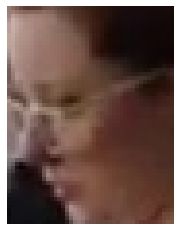

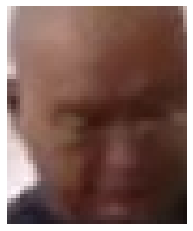

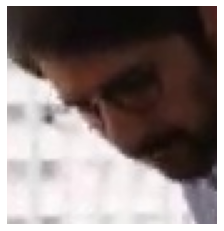

1/1 [==============================] - 0s 71ms/step


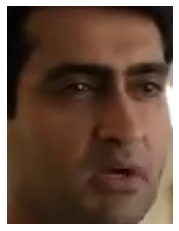

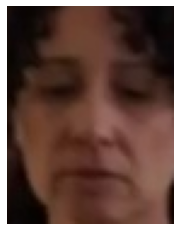

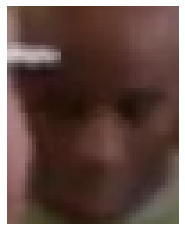

1/1 [==============================] - 0s 72ms/step


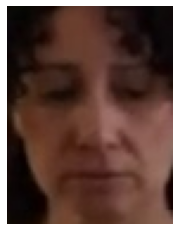

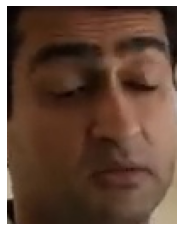

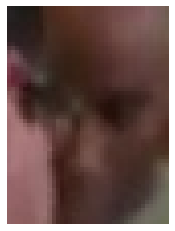

1/1 [==============================] - 0s 71ms/step


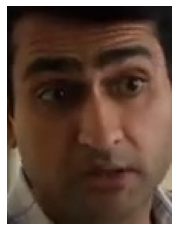

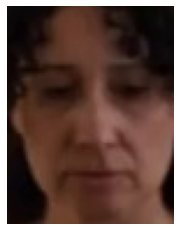

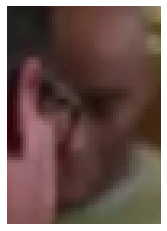

1/1 [==============================] - 0s 72ms/step


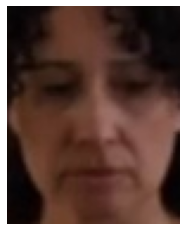

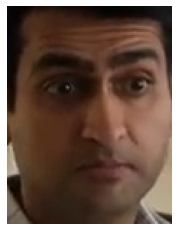

2/2 [==============================] - 0s 4ms/step


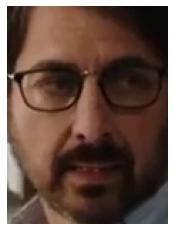

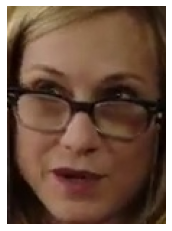

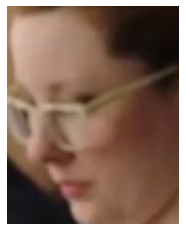

1/1 [==============================] - 0s 71ms/step


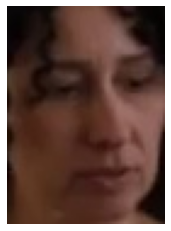

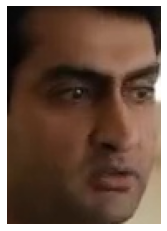

1/1 [==============================] - 0s 71ms/step


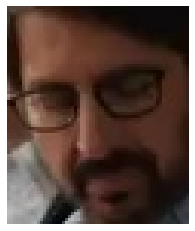

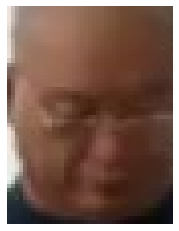

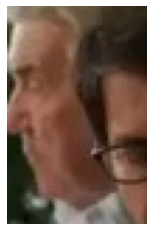

1/1 [==============================] - 0s 72ms/step


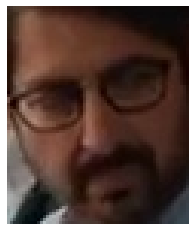

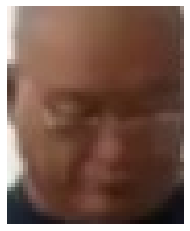

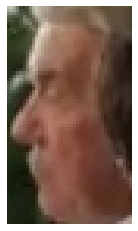

1/1 [==============================] - 0s 72ms/step


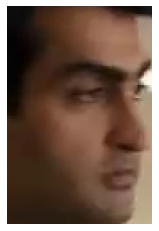

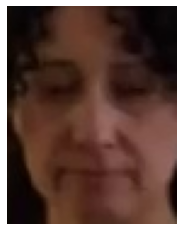

1/1 [==============================] - 0s 71ms/step


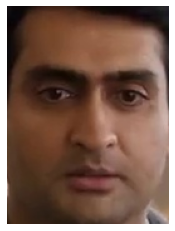

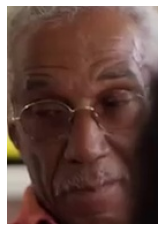

1/1 [==============================] - 0s 73ms/step


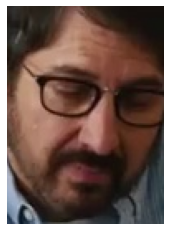

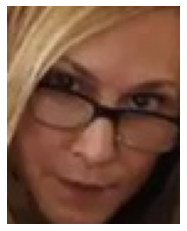

1/1 [==============================] - 0s 70ms/step


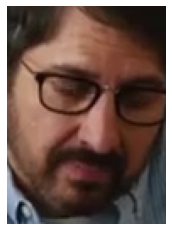

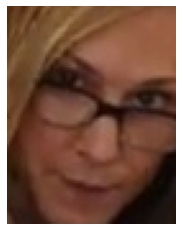

1/1 [==============================] - 0s 71ms/step


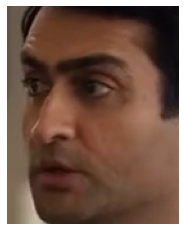

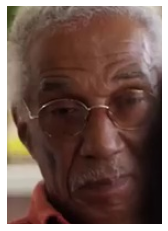

1/1 [==============================] - 0s 71ms/step


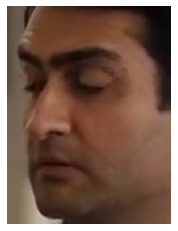

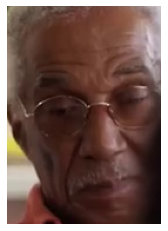

1/1 [==============================] - 0s 70ms/step


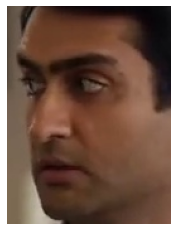

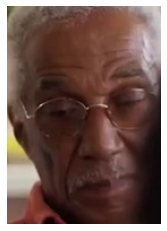

2/2 [==============================] - 0s 3ms/step


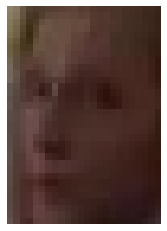

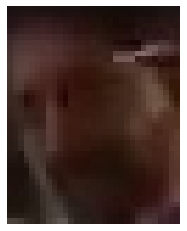

2/2 [==============================] - 0s 6ms/step


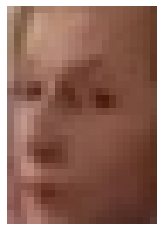

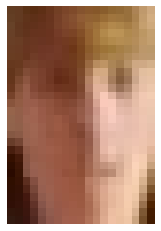

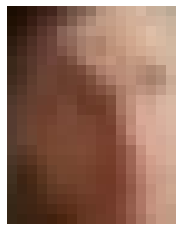

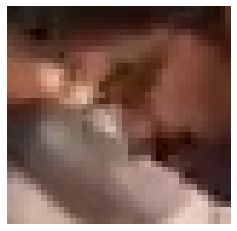

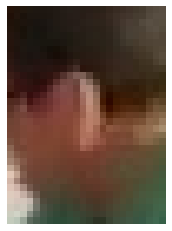

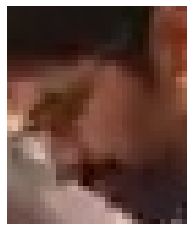

1/1 [==============================] - 0s 70ms/step


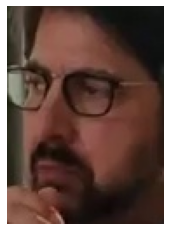

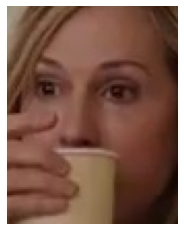

1/1 [==============================] - 0s 72ms/step


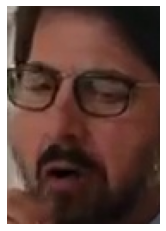

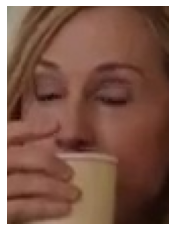

1/1 [==============================] - 0s 69ms/step


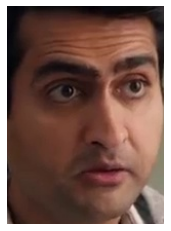

1/1 [==============================] - 0s 71ms/step


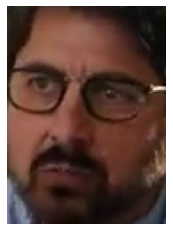

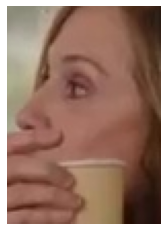

1/1 [==============================] - 0s 69ms/step


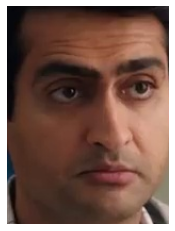

1/1 [==============================] - 0s 74ms/step


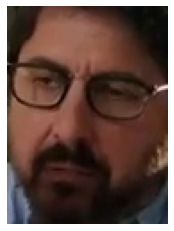

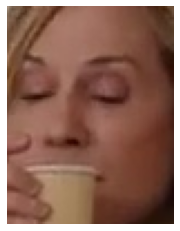

1/1 [==============================] - 0s 68ms/step


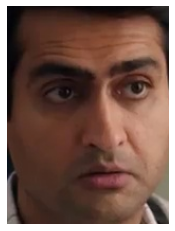

1/1 [==============================] - 0s 69ms/step


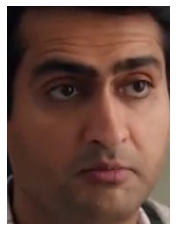

1/1 [==============================] - 0s 69ms/step


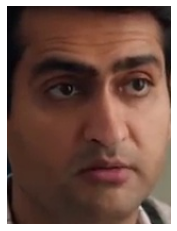

1/1 [==============================] - 0s 70ms/step


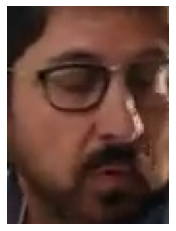

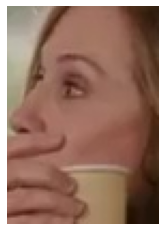

1/1 [==============================] - 0s 68ms/step


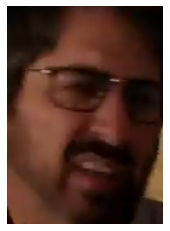

1/1 [==============================] - 0s 66ms/step


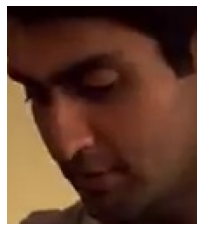

1/1 [==============================] - 0s 67ms/step


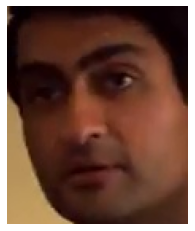

1/1 [==============================] - 0s 69ms/step


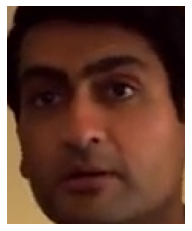

1/1 [==============================] - 0s 69ms/step


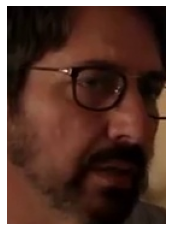

1/1 [==============================] - 0s 71ms/step


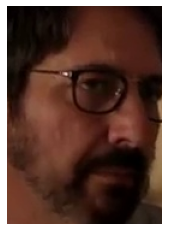

1/1 [==============================] - 0s 69ms/step


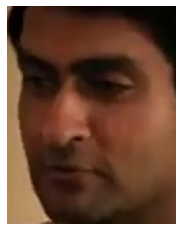

1/1 [==============================] - 0s 71ms/step


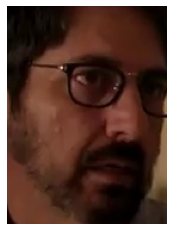

1/1 [==============================] - 0s 68ms/step


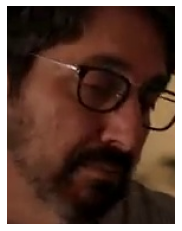

1/1 [==============================] - 0s 67ms/step


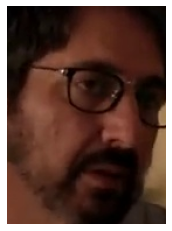

1/1 [==============================] - 0s 70ms/step


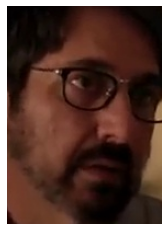

1/1 [==============================] - 0s 69ms/step


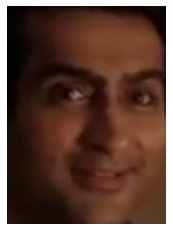

1/1 [==============================] - 0s 73ms/step


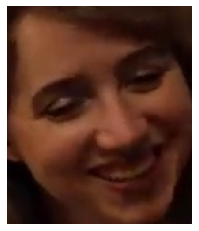

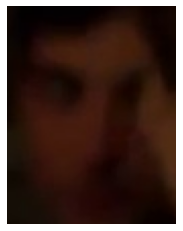

1/1 [==============================] - 0s 70ms/step


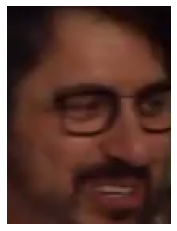

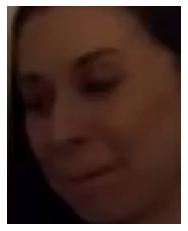

1/1 [==============================] - 0s 70ms/step


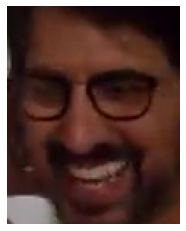

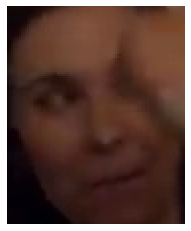

1/1 [==============================] - 0s 71ms/step


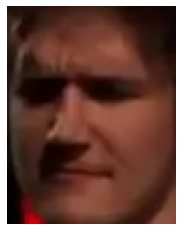

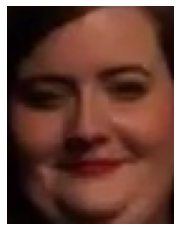

1/1 [==============================] - 0s 69ms/step


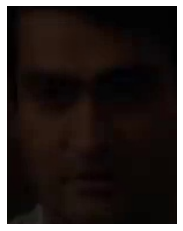

1/1 [==============================] - 0s 68ms/step


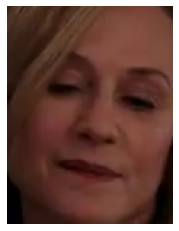

1/1 [==============================] - 0s 69ms/step


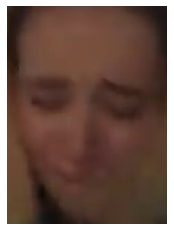

1/1 [==============================] - 0s 75ms/step


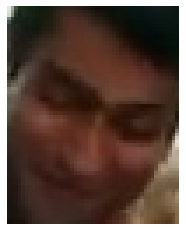

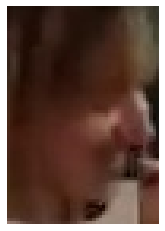

1/1 [==============================] - 0s 72ms/step


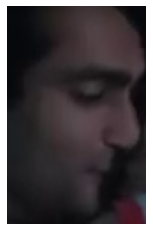

1/1 [==============================] - 0s 70ms/step


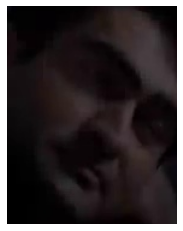

1/1 [==============================] - 0s 69ms/step


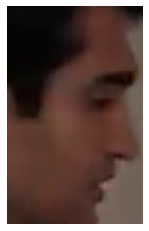

1/1 [==============================] - 0s 70ms/step


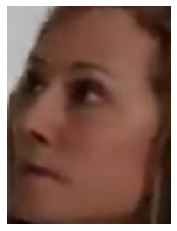

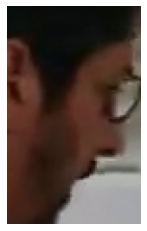

1/1 [==============================] - 0s 73ms/step


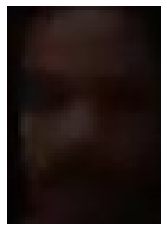

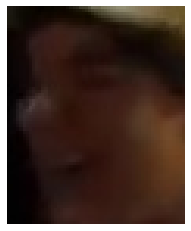

1/1 [==============================] - 0s 67ms/step


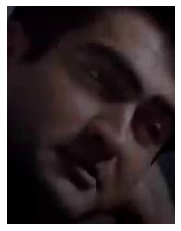

1/1 [==============================] - 0s 68ms/step


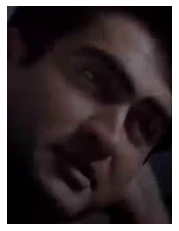

2/2 [==============================] - 0s 2ms/step


In [119]:
for i in range((math.floor(get_length("video.mp4")))):
    filename = './data/frame'+ str(i) +'.jpg'
    pixels = pyplot.imread(filename)
    detector = MTCNN()
    faces = detector.detect_faces(pixels)
    draw_faces(filename, faces, i)
    num = 0

In [120]:
def get_length(filename):
    result = subprocess.run(["ffprobe", "-v", "error", "-show_entries",
                             "format=duration", "-of",
                             "default=noprint_wrappers=1:nokey=1", filename],
        stdout = subprocess.PIPE,
        stderr = subprocess.STDOUT)
    return float(result.stdout)
facial_sentiment = []
temp = []
for i in range((math.floor(get_length("video.mp4")))):
    count = 0
    if (i % 5 == 0 and i != 0):
        facial_sentiment.append(temp)
        temp = []
    while(True):
        if(os.path.isfile("./test_images/" + str(i) + "-" +  str(count) + ".jpg") == True):
            temp.append(predict_image("./test_images/" + str(i) + "-" +  str(count) + ".jpg" , m))
            count += 1
        else:
             break

In [127]:
temp = []
mod = []
time2 = 0
for i in range(len(facial_sentiment)):
    for j in facial_sentiment[i]:
        temp.append(int(j))
    arr = np.asarray(temp)
    audio_label = int(audio_sentiment[i])
    if arr.size > 0:
        facial_label = int(stats.mode(arr).mode)
    else:
        facial_label = 'none'
    time2 += 5
    time1 = time2 - 5
    print('Seconds:', time1, 'to', time2)
    print('audio label:', labels[audio_label])
    print('facial label:', labels[facial_label])
    temp = []
    print('\n')

Seconds: 0 to 5
audio label: Happy
facial label: Angry


Seconds: 5 to 10
audio label: Happy
facial label: Happy


Seconds: 10 to 15
audio label: Angry
facial label: Sad


Seconds: 15 to 20
audio label: Disgusted
facial label: Neutral


Seconds: 20 to 25
audio label: Suprised
facial label: Sad


Seconds: 25 to 30
audio label: Angry
facial label: Happy


Seconds: 30 to 35
audio label: Angry
facial label: Sad


Seconds: 35 to 40
audio label: Angry
facial label: Happy


Seconds: 40 to 45
audio label: Happy
facial label: Happy


Seconds: 45 to 50
audio label: Disgusted
facial label: Angry


Seconds: 50 to 55
audio label: Disgusted
facial label: Neutral


Seconds: 55 to 60
audio label: Disgusted
facial label: Neutral


Seconds: 60 to 65
audio label: Disgusted
facial label: Angry


Seconds: 65 to 70
audio label: Disgusted
facial label: Angry


Seconds: 70 to 75
audio label: Happy
facial label: Happy


Seconds: 75 to 80
audio label: Disgusted
facial label: Sad


Seconds: 80 to 85
audio label:

KeyError: 'none'